In [2]:
import pandas as pd
import os
import numpy as np
import glob
from netCDF4 import Dataset,date2num,num2date
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import xlsxwriter

In [3]:
def extract_1(Var,min_index_lat,min_index_lon):
    cycle=np.array([Var[min_index_lat,min_index_lon],Var[min_index_lat+1,min_index_lon],
                    Var[min_index_lat-1,min_index_lon],Var[min_index_lat,min_index_lon+1],
                    Var[min_index_lat,min_index_lon-1]])
    cycle[cycle==0]=np.nan
    a=round(np.nanmean(cycle),0)
    return a
def extract_2(Var,min_index_lat,min_index_lon):
    cycle=np.array([Var[min_index_lat,min_index_lon],Var[min_index_lat+1,min_index_lon],
                    Var[min_index_lat-1,min_index_lon],Var[min_index_lat,min_index_lon+1],
                    Var[min_index_lat,min_index_lon-1]])
    cycle[cycle==0]=np.nan
    a=np.nanmean(cycle)
    return a

In [31]:
#read informations of gauge stations
stations=pd.read_excel(pd.ExcelFile("C:/Users/Admin/OneDrive/Desktop/gauges2.xlsx"))
#Choose a Case: Embedded/Squall line/Full stratiform
#Testing-Full stratiform:1,7,8,9,12,14,15/Squall line:2,6,8,10,11,12/Embedded:1,2,3,7,9,10,12,13,14,16,17,18,19
Case='Embedded.xlsx'
#Choose events of a case
Case_dic={Case:[str(i) for i in[1,2,3]]}
frames=[]
#sheets=[]
for r in Case_dic[Case]:
    #Gauges dataframe
    df_gauges=pd.read_excel('D:\gauge datas 2021\Testing cases/'+Case,sheet_name=r)
    #netCDF SVM dataframe
    linkNC='E:/SVM_netCDF/'+Case[:-5]+'/'+r+'/'
    df_CS_SVM=pd.DataFrame(0,columns=df_gauges.columns[3:],index=stations['Tên Trạm'])
    df_Zh=pd.DataFrame(0,columns=df_gauges.columns[3:],index=stations['Tên Trạm'])
    df_ZDR=pd.DataFrame(0,columns=df_gauges.columns[3:],index=stations['Tên Trạm'])
    df_KDP=pd.DataFrame(0,columns=df_gauges.columns[3:],index=stations['Tên Trạm'])
    n=0
    for file_name in os.listdir(linkNC):
        data=Dataset(linkNC+file_name,'r') # at 1 time
        for index,row in stations.iterrows():
            locations=row['Tên Trạm']
            location_lat=row['Latitude']
            location_lon=row['Longitude']
            lat=data.variables['latitude'][:]
            lon=data.variables['longitude'][:]
            sq_diff_lat=(lat-location_lat)**2
            sq_diff_lon=(lon-location_lon)**2
            min_index_lat=sq_diff_lat.argmin()
            min_index_lon=sq_diff_lon.argmin()
            df_CS_SVM.loc[[locations],list(df_gauges.columns[3:])[n]]=extract_1(data.variables['CS_SVM'][0,:,:].filled(fill_value=0.0)
                                                                              ,min_index_lat,min_index_lon)
            df_Zh.loc[[locations],list(df_gauges.columns[3:])[n]]=extract_2(data.variables['Zh_1.5km'][:][0,:,:].filled(fill_value=0.0)
                                                                         ,min_index_lat,min_index_lon)
            df_ZDR.loc[[locations],list(df_gauges.columns[3:])[n]]=extract_2(data.variables['ZDR_1.5km'][:][0,:,:].filled(fill_value=0.0)
                                                                         ,min_index_lat,min_index_lon)
            df_KDP.loc[[locations],list(df_gauges.columns[3:])[n]]=extract_2(data.variables['KDP_1.5km'][:][0,:,:].filled(fill_value=0.0)
                                                                         ,min_index_lat,min_index_lon)
            
        n=n+1
    df=pd.DataFrame(data={
    'Stations': list(df_gauges['Trạm Đo'][:])*df_gauges.columns[3:].size,
    'times': list(np.repeat(df_gauges.columns[3:],df_gauges['Trạm Đo'].size)),
    'R_10m':list(pd.Series(df_gauges.iloc[:,3:].values.ravel('F'))),
    'SC_SVM':list(pd.Series(df_CS_SVM.iloc[:,:].values.ravel('F'))),
    'Z_1500m':list(pd.Series(df_Zh.iloc[:,:].values.ravel('F'))),
    'ZDR_1500m':list(pd.Series(df_ZDR.iloc[:,:].values.ravel('F'))),
    'KDP_1500m':list(pd.Series(df_KDP.iloc[:,:].values.ravel('F')))  
    })
    df=df.fillna(0)
    frames.append(df)
    #sheets.append(str(r))
#out_path = r"D:/gauge datas 2021/QPE_gauges/"+Case
#writer = pd.ExcelWriter(out_path,engine='xlsxwriter')   
#for dataframe, sheet in zip(frames, sheets):
#   dataframe.to_excel(writer, sheet_name=sheet, startrow=0 , startcol=0,na_rep='',float_format="%.2f",index=False)   
#writer.save()
result = pd.concat(frames,ignore_index=True)
df_Stratform=result.loc[(result.R_10m>0)&(result.SC_SVM==1)&(result.Z_1500m>0)]
df_Convection=result.loc[(result.R_10m>0)&(result.SC_SVM==2)&(result.Z_1500m>0)]
zz=[df_Stratform,df_Convection]
sheets=['Stratiform','Convection']
out_path = r"D:/gauge datas 2021/QPE_gauges/"+Case
writer = pd.ExcelWriter(out_path,engine='xlsxwriter')   
for dataframe, sheet in zip(zz, sheets):
    dataframe.to_excel(writer, sheet_name=sheet, startrow=0 , startcol=0,na_rep='',float_format="%.2f",index=False)   
writer.save()

In [7]:
# Packages for analysis
import pandas as pd
import numpy as np
from numpy import dtype
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from netCDF4 import Dataset,date2num,num2date
from datetime import datetime,timedelta
from wradlib.trafo import r_to_depth

# Packages for visuals
import matplotlib.pyplot as plt

# Allows charts to appear in the notebook
%matplotlib inline

import pyart
import numpy.ma as ma
import matplotlib.ticker as mticker
from matplotlib import colors as c
from matplotlib.colors import ListedColormap,BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.geodesic as cargeo
from shapely.geometry import Polygon
import os
import warnings
warnings.filterwarnings('ignore')

In [8]:
lon=data.variables['longitude'][:]
lat=data.variables['latitude'][:]
lons,lats=np.meshgrid(lon,lat)

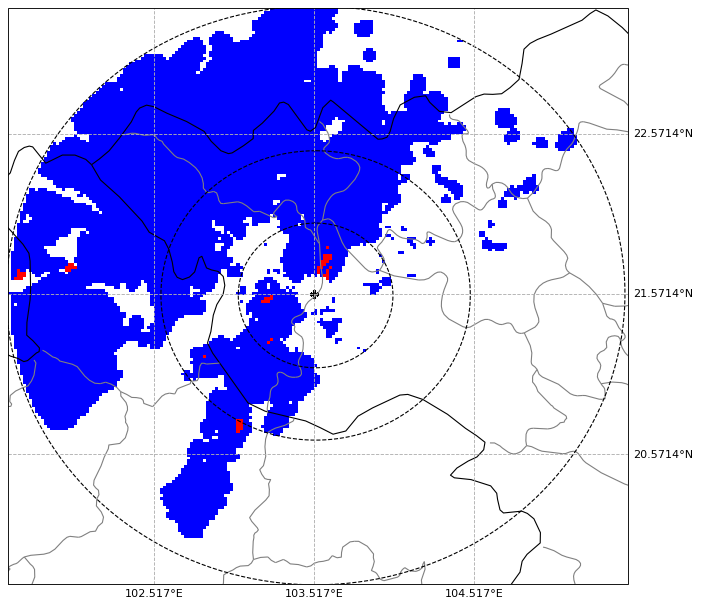

In [57]:
# Draw Range_Rings
circle_points_50km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=50000, n_samples=180, endpoint=False)
circle_points_100km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=100000, n_samples=180, endpoint=False)
circle_points_200km= cargeo.Geodesic().circle(lon=103.526,lat=21.5632, radius=200000, n_samples=180, endpoint=False)
geom_50km=Polygon(circle_points_50km)
geom_100km=Polygon(circle_points_100km)
geom_200km=Polygon(circle_points_200km)
# Read file netCDF and prepare datas to plot
fig=plt.figure(figsize=(10,15),dpi=80)
ax1=fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax1.add_feature(cfeat.LAND)
ax1.add_feature(cfeat.OCEAN.with_scale('10m'))
ax1.add_feature(cfeat.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeat.BORDERS.with_scale('50m'))
state_provinces_lines=cfeat.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none')
ax1.add_feature(state_provinces_lines,edgecolor='gray')
g1=ax1.gridlines(draw_labels=True,linestyle='--')
g1.xlabels_top = False
g1.ylabels_left = False
g1.xlocator = mticker.FixedLocator([102.51694002747536, 103.51694002747536, 104.51694002747536, 105.51694002747536])
g1.ylocator = mticker.FixedLocator([20.571390070021152,21.571390070021152,22.571390070021152])
ax1.set_extent((lon[0],lon[-1],lat[0],lat[-1]),crs=ccrs.PlateCarree())
ax1.add_geometries((geom_50km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_100km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
ax1.add_geometries((geom_200km,), crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1, linestyle='--')
cMap = c.ListedColormap(['w','b','r'])
z1_plot=ax1.pcolormesh(lons,lats,data.variables['CS_SVM'][0,:,:].filled(fill_value=0),shading='flat',cmap=cMap)
ax1.scatter(x=103.51694002747536,y=21.571390070021152,transform=ccrs.PlateCarree(), color="black",s=50, alpha=1,marker='P')
#ax1.set(title="SVM "+str(date_range[1]) )
#plt.colorbar(z1_plot,ax=ax1,orientation='horizontal', label='mm');

In [124]:
data.variables['Zh_1.5km'][:][0,:,:].filled(fill_value=0.0).max()

42.696407

float

In [67]:
j[j!=0.].mean()

AttributeError: 'float' object has no attribute 'mean'